## This script recreates all the tables from the paper 
 
- Table 1, 2, S2, S3
- Figure S1

## Requirements:

- The directory "experiments/metrics" must be full of all the metric files (should be 72 files)
- The directory "results_50_230521" must have `res_*.csv` files. 

5000
500
8000
1000
10000
3000


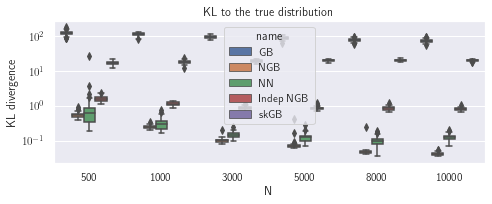

In [25]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import string
result_dir = "../simulation_example/results_50_230521/"
from probdrift import mpl_config
## Global configuration for tables
from universals import METHOD_ORDER, METRIC_ORDER
plt.rcParams.update(mpl_config)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)



def add_letters(axs):
    for n, ax in enumerate(axs.flatten()):
        ax.text(-0.3, 0.5, "\\textbf{"+ string.ascii_uppercase[n]+")}", transform=ax.transAxes, 
            size=13, weight='bold')

files = [result_dir+i for i in os.listdir(result_dir) if '.csv' in i]
files
df_list = []

for fname in files:
    N = fname.split("_")[-1][:-4]
    print(N)
    df = pd.read_csv(fname)
    df['rep'] = df.groupby('name').cumcount()+1
    df['N'] = int(N) 
    df_list.append(df)
full_results = pd.concat(df_list).sort_values(['rep','N']).reset_index(drop=True)
full_results.head()

def get_best_NN(full_results, method = 1, metric = 'logllh'):
    """
    Function to select best neural network hyper-parameter set
    
    method = 1 will choose the best per replication
    method = 2 will choose the best per value $N$
    """
    mask = ["NN" in i for i in full_results['name']]
    NN_df = full_results[mask]
    if method==1:
        new_df = NN_df.groupby(['rep','N'], group_keys=False).apply(
            lambda x: x.sort_values(metric, ascending=False).head(1)
        ).reset_index(drop=True)
    else:
        best = (NN_df
        .groupby(['N','name'], group_keys=False)
        .mean(metric)
        .sort_values(metric, ascending=False)
        .groupby('N')
        .head(1)
        .reset_index()[['N','name']])
        new_df = NN_df.merge(best, left_on=['N', 'name'], right_on=['N','name'])

    
    return new_df
subset = ['NGB', 'GB', 'indep_NGB', 'skGB']
GB_results = full_results.query("name in @subset")

method = 2
metric = 'logllh'


NN_res = get_best_NN(full_results, method=method, metric=metric)
NN_res['oldname'] =  NN_res['name']
NN_res['name'] = 'NN'

summarised = pd.concat([GB_results, NN_res], ignore_index=True,)
results_to_plot = summarised



sns.set_theme()
fig, axs = plt.subplots(1,1,figsize=[7,3])

results_to_plot.sort_values("name", inplace=True)

## Remap names to make them human readable
names = results_to_plot['name'].unique()
remap = {name:name for name in names}
remap['indep_GB'] = 'Indep GB'
remap['indep_NGB'] = 'Indep NGB'
results_to_plot['name'] = results_to_plot['name'].map(remap)
results_to_plot['RMSE'] = results_to_plot.eval("sqrt(0.5*MSE_x+0.5*MSE_y)")

sns.boxplot(
    data=results_to_plot, x="N", y="KL_div", hue="name",
ax = axs)
axs.set_ylabel("KL divergence")
axs.set_title("KL to the true distribution")
summ_df = full_results.groupby(['name', 'N']).aggregate(["mean", 'std'])
summ_df.columns = ["_".join(x) for x in summ_df.columns]
axs.set(yscale="log")
#add_letters(axs)
fig.tight_layout()
fig.savefig("../Images/simulation_metrics.pdf")

# Figure S1 is below

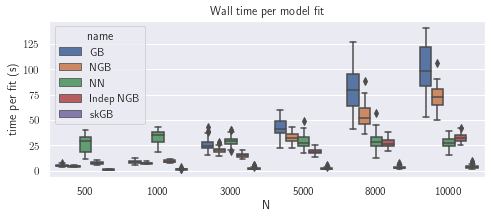

In [26]:
sns.set_theme()
fig, axs = plt.subplots(1,1,figsize=[7,3])
sns.boxplot(
    data=results_to_plot, x="N", y="time", hue="name",
ax = axs)
axs.set_ylabel("time per fit (s)")
fig.tight_layout()
axs.set_title("Wall time per model fit")
fig.savefig("../Images/walltime.pdf")

In [27]:
results_to_plot

,name,logllh,KL_div,time,NLL,MSE_x,MSE_y,ES,coverage,area,rep,N,oldname,RMSE
478,GB,-1.776188,98.740855,77.917883,1.776188,0.441712,5.147594,1.184529,0.905,6.770798,20,10000,NaN,1.671722
726,GB,-2.287867,120.870633,8.284695,2.287867,0.480588,6.301194,1.331306,0.836,7.402926,31,1000,NaN,1.841437
226,GB,-2.049976,112.563566,22.692291,2.049976,0.455832,5.931708,1.275669,0.883,7.658601,10,3000,NaN,1.787112
1070,GB,-1.848901,88.089858,50.974054,1.848901,0.415727,4.753047,1.126397,0.877,6.339555,45,5000,NaN,1.607603
394,GB,-2.065432,100.068488,36.042903,2.065432,0.447262,5.617562,1.238278,0.874,7.173118,17,3000,NaN,1.741382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,skGB,-2.098457,16.405925,1.214143,2.098457,0.382027,0.480287,0.560041,0.797,4.063187,22,500,NaN,0.656625
768,skGB,-1.987092,19.228802,0.701852,1.987092,0.368495,0.470100,0.556145,0.842,4.857714,33,500,NaN,0.647532
508,skGB,-1.954472,16.241423,1.140856,1.954472,0.325896,0.493583,0.550470,0.823,4.590775,22,1000,NaN,0.640109
488,skGB,-1.905645,21.069844,1.084774,1.905645,0.360167,0.424616,0.533265,0.866,5.053733,21,3000,NaN,0.626412


In [4]:
N_df = results_to_plot.groupby(['name', 'N']).mean()[["KL_div"]+METRIC_ORDER]
supplementary_table = N_df.melt(ignore_index=False).reset_index().pivot(["variable","N"], 'name')
N_df = results_to_plot.groupby(['name', 'N']).std()[["KL_div"]+METRIC_ORDER]
supplementary_table_std = N_df.melt(ignore_index=False).reset_index().pivot(["variable","N"], 'name')
supplementary_table.index.names = ["Metric", "N"]
supplementary_table.columns.name=''
supplementary_table.columns = [i[1] for i in supplementary_table.columns]
supplementary_table_std.columns.name=''
supplementary_table_std.columns = [i[1] for i in supplementary_table_std.columns]
supplementary_table = supplementary_table[METHOD_ORDER]
supplementary_table_std = supplementary_table_std[METHOD_ORDER]

In [5]:
summs = results_to_plot.groupby(['name', 'N']).agg(["mean","std"])[['KL_div']+METRIC_ORDER].melt(ignore_index=False).reset_index().pivot(['variable_1','variable_0', 'N'],'name')
summs.columns.name = ''
summs.columns = [i[1] for i in summs.columns]
summs
supplementary_table = summs.loc["mean"][METHOD_ORDER]
supplementary_table_std = summs.loc["std"][METHOD_ORDER]

In [6]:
summs

GB  Indep NGB       NGB        NN  \
variable_1 variable_0 N                                                  
mean       KL_div     500    126.226568   1.632862  0.563568  1.284921   
                      1000   114.112886   1.150469  0.256601  0.320444   
                      3000    97.681955   0.884165  0.105593  0.149290   
                      5000    90.101001   0.878116  0.080595  0.127653   
                      8000    79.005706   0.865891  0.053179  0.103248   
                      10000   74.798945   0.831488  0.043065  0.129818   
           NLL        500      2.488247   1.268637  1.348427  1.048054   
                      1000     2.252612   1.104845  1.015533  0.888449   
                      3000     2.005851   1.015283  0.837934  0.831976   
                      5000     1.892735   0.976874  0.790978  0.809020   
                      8000     1.797929   0.971998  0.777084  0.802930   
                      10000    1.754584   0.972020  0.774575  0.819900   
           RMSE       500      1.906402   0.653252  0.658193  0.645219   
                      1000     1.847744   0.627661  0.630459  0.615720   
                      3000     1.757678   0.624370  0.625407  0.621387   
                      5000     1.704518   0.617328  0.617629  0.616995   
                      8000     1.651280   0.617505  0.617783  0.617588   
                      10000    1.635708   0.620053  0.620293  0.620808   
           area       500      8.570523   2.591434  1.897016  3.019140   
                      1000     7.736925   2.520844  1.966491  2.640017   
                      3000     7.211628   2.596404  2.223719  2.577721   
                      5000     6.893198   2.654455  2.304531  2.606740   
                      8000     6.494016   2.690307  2.364937  2.648244   
                      10000    6.368511   2.692041  2.378770  2.625582   
           coverage   500      0.844020   0.832400  0.756440  0.883220   
                      1000     0.856840   0.847520  0.799560  0.892420   
                      3000     0.880120   0.862540  0.847720  0.890280   
                      5000     0.891020   0.874040  0.866540  0.896200   
                      8000     0.895740   0.877200  0.873420  0.896300   
                      10000    0.896420   0.879460  0.875380  0.896740   
std        KL_div     500     18.232853   0.306323  0.115103  3.865228   
                      1000    11.467170   0.142480  0.028534  0.129010   
                      3000     9.877766   0.105965  0.016644  0.031504   
                      5000     9.131863   0.103546  0.053454  0.035821   
                      8000     8.260034   0.092583  0.028772  0.031265   
                      10000    8.425120   0.071895  0.004164  0.026836   
           NLL        500      0.087473   0.066887  0.114313  0.164659   
                      1000     0.064140   0.050010  0.065932  0.056013   
                      3000     0.065147   0.052789  0.054596  0.055261   
                      5000     0.049382   0.050074  0.051291  0.049800   
                      8000     0.080030   0.044863  0.046644  0.049256   
                      10000    0.061453   0.042017  0.039967  0.039267   
           RMSE       500      0.059179   0.016965  0.017777  0.026027   
                      1000     0.049679   0.012626  0.013100  0.011923   
                      3000     0.041421   0.014855  0.014726  0.013991   
                      5000     0.043169   0.015189  0.015058  0.015243   
                      8000     0.046755   0.014863  0.014784  0.015303   
                      10000    0.043102   0.014639  0.014647  0.014202   
           area       500      0.712953   0.195493  0.120326  0.503036   
                      1000     0.504276   0.126706  0.090967  0.161930   
                      3000     0.438670   0.100257  0.071244  0.165707   
                      5000     0.328646   0.092394  0.068576  0.209620   
                      8000     0.356844  

In [7]:
latex_df = supplementary_table.copy()
N,p = supplementary_table.shape
N_rep = 50
n_round = 2
def pad_num(x):
    out = str(x)
    ind = out.index('.')
    out = out+(n_round-(len(out)-(ind+1)))*"0"
    return out
for i in range(N):
    #6 values of N, 3 rows where a best can be chosen
    if i<(6*3):
        best  = np.argmin(supplementary_table.iloc[i,:])
    else:
        best =-1
    for j in range(p):
        _str = f"{pad_num(np.round(supplementary_table.iloc[i,j],2))} ± {pad_num(np.round(supplementary_table_std.iloc[i,j]/np.sqrt(50), 2))}" 
        if best == j:
            _str = "\textbf{"+_str+"}"
        latex_df.iloc[i,j] = _str

In [8]:
print(latex_df.to_latex(multirow=True, escape=False))

\begin{tabular}{lllllll}
\toprule
         &       &                   NGB &             Indep NGB &          skGB &             GB &                    NN \\
variable_0 & N &                       &                       &               &                &                       \\
\midrule
\multirow{6}{*}{KL_div} & 500   &  \textbf{0.56 ± 0.02} &           1.63 ± 0.04 &  17.19 ± 0.30 &  126.23 ± 2.58 &           1.28 ± 0.55 \\
         & 1000  &  \textbf{0.26 ± 0.00} &           1.15 ± 0.02 &  17.96 ± 0.27 &  114.11 ± 1.62 &           0.32 ± 0.02 \\
         & 3000  &  \textbf{0.11 ± 0.00} &           0.88 ± 0.01 &  19.61 ± 0.25 &   97.68 ± 1.40 &           0.15 ± 0.00 \\
         & 5000  &  \textbf{0.08 ± 0.01} &           0.88 ± 0.01 &  20.31 ± 0.17 &   90.10 ± 1.29 &           0.13 ± 0.01 \\
         & 8000  &  \textbf{0.05 ± 0.00} &           0.87 ± 0.01 &  20.61 ± 0.17 &   79.01 ± 1.17 &           0.10 ± 0.00 \\
         & 10000 &  \textbf{0.04 ± 0.00} &           0.83 ± 0.01 &  2

In [9]:
summ_df = (results_to_plot
            .pivot_table(index="N", columns="name" , values='KL_div', aggfunc=['mean', 'std','count'])
            .reorder_levels([1,0],axis=1).sort_index(axis=1)
          )
summ_df
latex_df = pd.DataFrame(index=summ_df.index)
summ_df.columns
for i in METHOD_ORDER:
    latex_df[i] = summ_df[i].apply(lambda x: f"{np.round(x['mean'],3)}±{np.round(x['std']/np.sqrt(x['count']), 3)}", axis=1)
latex_df= latex_df.round(3)

## Table 1

In [10]:
latex_df
print(latex_df.to_latex())

\begin{tabular}{llllll}
\toprule
{} &          NGB &    Indep NGB &          skGB &             GB &           NN \\
N     &              &              &               &                &              \\
\midrule
500   &  0.564±0.016 &  1.633±0.043 &  17.194±0.301 &  126.227±2.579 &  1.285±0.547 \\
1000  &  0.257±0.004 &    1.15±0.02 &   17.963±0.27 &  114.113±1.622 &   0.32±0.018 \\
3000  &  0.106±0.002 &  0.884±0.015 &  19.609±0.248 &   97.682±1.397 &  0.149±0.004 \\
5000  &  0.081±0.008 &  0.878±0.015 &  20.308±0.169 &   90.101±1.291 &  0.128±0.005 \\
8000  &  0.053±0.004 &  0.866±0.013 &   20.614±0.17 &   79.006±1.168 &  0.103±0.004 \\
10000 &  0.043±0.001 &   0.831±0.01 &   20.554±0.15 &   74.799±1.191 &   0.13±0.004 \\
\bottomrule
\end{tabular}



In [11]:
latex_df

,NGB,Indep NGB,skGB,GB,NN
N,,,,,
500,0.564±0.016,1.633±0.043,17.194±0.301,126.227±2.579,1.285±0.547
1000,0.257±0.004,1.15±0.02,17.963±0.27,114.113±1.622,0.32±0.018
3000,0.106±0.002,0.884±0.015,19.609±0.248,97.682±1.397,0.149±0.004
5000,0.081±0.008,0.878±0.015,20.308±0.169,90.101±1.291,0.128±0.005
8000,0.053±0.004,0.866±0.013,20.614±0.17,79.006±1.168,0.103±0.004
10000,0.043±0.001,0.831±0.01,20.554±0.15,74.799±1.191,0.13±0.004


## NAO Results 

In [12]:
metrics_dir = "../experiments/metrics/"

In [13]:
all_metrics = [pd.read_csv(metrics_dir+_file,index_col=0) for _file in os.listdir(metrics_dir)]
def transform_df(df):
    df['RMSE_x'] = np.sqrt(df['MSE_x'])
    df['RMSE_y'] = np.sqrt(df['MSE_y'])
    df['RMSE'] = np.sqrt(df['MSE_x']/2+df['MSE_y']/2)
    return df
all_metrics = list(map(transform_df, all_metrics))


In [14]:
summaries = {df['name'].iloc[0]: df.mean().to_dict() for df in all_metrics}
summary_df = pd.DataFrame(summaries).T
summary_df =(summary_df
    .reset_index()
    .rename({"index":"fname"},axis=1))
summary_df['name'] = summary_df['fname'].str[3:]

Just for context we show the variation over the neural network structures/learning rates here. 
Odd numbers have a learning rate of 0.001 even have a learning rate of 0.01. 

In [15]:
summary_df[['nn' in i for i in summary_df['fname']]].sort_values("NLL")

,fname,NLL,MSE_x,MSE_y,ES,coverage,area,RMSE_x,RMSE_y,RMSE,name
42,071nn,7.814386,277.953391,275.895283,12.026070,0.890064,3670.080011,16.660271,16.601658,16.631753,nn
43,069nn,7.845965,291.929101,285.234708,12.233132,0.891592,3903.431499,17.068793,16.878936,16.975100,nn
55,065nn,7.880438,318.734454,289.773233,12.505787,0.887227,4039.866462,17.822162,17.010662,17.422478,nn
67,067nn,7.898012,312.317156,293.302584,12.523984,0.893748,4097.344567,17.651640,17.114772,17.386409,nn
60,063nn,7.905039,326.828955,296.975590,12.643966,0.891394,4288.044175,18.053911,17.222740,17.644431,nn
13,070nn,7.925246,296.356660,289.010543,12.586323,0.896088,4436.081603,17.193384,16.985135,17.090564,nn
0,068nn,7.939278,303.556526,292.177049,12.730234,0.892730,4581.671364,17.393591,17.077804,17.237462,nn
11,066nn,7.953270,316.810359,293.104999,12.723035,0.894951,4523.825736,17.780512,17.109465,17.448950,nn
16,061nn,7.993247,327.513842,305.716249,12.986051,0.893676,4945.176987,18.074421,17.467238,17.773842,nn
6,064nn,7.994044,331.317816,299.068086,13.018421,0.898566,4947.446248,18.183531,17.282993,17.739617,nn


If we compare the above to the ngboost results below we see much less sensitivity.

In [16]:
summary_df[[i=="mvn_ngboost" for i in summary_df['name']]].sort_values("NLL")

,fname,NLL,MSE_x,MSE_y,ES,coverage,area,RMSE_x,RMSE_y,RMSE,name
2,045mvn_ngboost,7.734417,214.716405,207.881211,11.100800,0.866784,2481.714952,14.646032,14.413228,14.530361,mvn_ngboost
29,027mvn_ngboost,7.735354,211.380376,207.318067,11.078750,0.869075,2480.836550,14.530393,14.393578,14.462427,mvn_ngboost
22,036mvn_ngboost,7.736292,213.642224,207.629789,11.102747,0.867260,2482.998723,14.610359,14.403959,14.507682,mvn_ngboost
34,042mvn_ngboost,7.739826,215.988410,208.419309,11.130134,0.866835,2484.602354,14.689158,14.431046,14.560856,mvn_ngboost
56,018mvn_ngboost,7.740714,214.789541,209.699861,11.140017,0.873748,2595.874398,14.648609,14.475685,14.562589,mvn_ngboost
35,033mvn_ngboost,7.741392,214.422465,207.224901,11.115055,0.866510,2477.781328,14.636252,14.390936,14.514387,mvn_ngboost
1,024mvn_ngboost,7.741617,212.264260,207.459086,11.096052,0.868904,2489.069148,14.562600,14.398433,14.480938,mvn_ngboost
46,015mvn_ngboost,7.744648,214.892111,209.157841,11.143558,0.873631,2586.686247,14.651976,14.457376,14.555233,mvn_ngboost
12,039mvn_ngboost,7.749058,218.885140,209.484819,17.588307,0.867901,5628.806614,14.787468,14.468414,14.629044,mvn_ngboost
18,030mvn_ngboost,7.756843,218.265687,208.409630,11.615465,0.867090,3220.504481,14.764982,14.431714,14.599622,mvn_ngboost


In [17]:
num_list = summary_df['fname'].str[:3].apply(lambda x: int(x)).to_list()

In [18]:
top_of_each = (summary_df
    .groupby('name',as_index=False)
    .apply(lambda x: x.sort_values('NLL').head(1))
    .reset_index(drop=True))
best_names = top_of_each['fname'].to_list()

In [19]:
result_df = summary_df.query("fname in @best_names").copy()

# Best configuration files from each class of models: 

In [20]:
best_names

['053GBM',
 '004LGBM',
 '029indep_ngboost',
 '045mvn_ngboost',
 '028mvn_ngboost_og',
 '071nn']

In [21]:
result_df = pd.concat([df for df in all_metrics if df['name'].iloc[0] in best_names])
result_df['model_name'] = result_df['name'].str[3:]

rename_methods = {"mvn_ngboost": "NGB",
                    "indep_ngboost": "Indep NGB",
                    "mvn_ngboost_og": "GB",
                    "nn": "NN",
                    #"LGBM": "LGBM",
                     "GBM": "skGB"}
result_df['model_name'] = result_df['model_name'].map(rename_methods)

In [22]:
summ_df = result_df.groupby('model_name')[['NLL', 'RMSE', 'ES','coverage', 'area']].aggregate(['mean', 'std', 'count'])

# Table 2 from the main paper

In [23]:
summ_df = summ_df.sort_values(("NLL", 'mean'))
summ_df
latex_df = pd.DataFrame(index=summ_df.index)
summ_df.columns
for i in summ_df.columns:
    if i[0]=='area':
        num_dig = 0
    else:
        num_dig = 2
    latex_df[i[0]] = summ_df[i[0]].apply(lambda x: f"{np.round(x['mean'],num_dig)}±{np.round(x['std']/np.sqrt(x['count']), num_dig)}", axis=1)
latex_df = latex_df[METRIC_ORDER].T[METHOD_ORDER]

latex_df.columns.name = None

In [24]:
print(latex_df.to_latex())

\begin{tabular}{llllll}
\toprule
{} &          NGB &    Indep NGB &        skGB &           GB &           NN \\
\midrule
NLL      &    7.73±0.02 &    7.74±0.02 &   8.17±0.02 &    8.79±0.01 &    7.81±0.02 \\
RMSE     &   14.53±0.14 &   14.45±0.12 &  14.31±0.13 &   24.14±0.36 &   16.63±0.19 \\
coverage &     0.87±0.0 &     0.87±0.0 &    0.89±0.0 &     0.94±0.0 &     0.89±0.0 \\
area     &  2482.0±51.0 &  2568.0±41.0 &  2714.0±8.0 &  8070.0±22.0 &  3670.0±75.0 \\
\bottomrule
\end{tabular}

